In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import math
import numpy as np
import torch
import torchvision.utils
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity
from torch import nn
import torch.nn.functional as F
from proj.show import imsshow
from proj.resblock import ResBlock

## 读取第一题的数据并分隔

In [2]:
img_recon = np.load('data/data_after_prob1.npz')["recon"]
img_fully = np.load('data/cine.npz')['dataset']
mask= np.load('data/data_after_prob1.npz')['mask']

In [3]:
# normalize the images
def normalize(img):
    img = (img - img.min()) / (img.max() - img.min()+1e-8)
    return img
img_fully = normalize(img_fully)
img_recon = normalize(img_recon)
#imsshow(img_fully[0],num_col=5,cmap='gray', is_colorbar=True)

In [4]:
# split the 200 data into 5:1:2 train(125), val(25), test(50)
train_label = img_fully[:125]
train_data = img_recon[:125]
#train_label = np.concatenate([train_label, np.rot90(train_label, 1, axes=(2, 3))])
#train_label = np.concatenate([train_label, np.rot90(train_label, 2, axes=(2, 3))])
#train_data = np.concatenate([train_data, np.rot90(train_data, 1, axes=(2, 3))])
#train_data = np.concatenate([train_data, np.rot90(train_data, 2, axes=(2, 3))])
print(train_label.shape,train_data.shape)
val_label = img_fully[125:150]
val_data = img_recon[125:150]
test_label = img_fully[150:]
test_data = img_recon[150:]

(125, 20, 192, 192) (125, 20, 192, 192)


In [5]:
# convert the numpy array to torch tensor
train_data = torch.from_numpy(train_data).float()
train_label = torch.from_numpy(train_label).float()
val_data = torch.from_numpy(val_data).float()
val_label = torch.from_numpy(val_label).float()
test_data = torch.from_numpy(test_data).float()
test_label = torch.from_numpy(test_label).float()
train = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label), batch_size=5, shuffle=True)
val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data, val_label), batch_size=5, shuffle=True)
test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label), batch_size=5, shuffle=True)

In [6]:
#简单模型
class ResBlock_Mini(nn.Module):
    def __init__(self):
        super(ResBlock_Mini, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1) # 输出维度: (16, 20, 192, 192)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1) # 输出维度: (32, 10, 96, 96)
        self.conv7 = nn.Conv3d(32, 16, kernel_size=3, padding=1)
        self.conv8 = nn.Conv3d(16, 1, kernel_size=3, padding=1)
    def forward(self, x):
        identity = x
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv7(out))
        out = self.conv8(out)
        out += identity
        return out

Training on cuda:0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Validation PSNR: 25.195605271932184
Validation SSIM: 0.6516664241111073
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Validation PSNR: 26.263577155985722
Validation SSIM: 0.6999423806125041
Epoch 11
Epoch 12
Epoch 13


KeyboardInterrupt: 

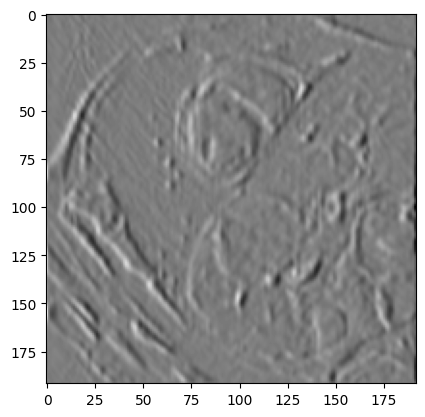

In [9]:
from proj.resblock import ResBlock
from proj.loss_util import PerceptualLoss, edge_loss
# train resnet
########################################### The model with edge loss ###########################################
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
# Complex model：
model = ResBlock().to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), weight_decay=1e-9)#较小的weight_decay效果较好
a = 0.2
edge_loss_start = 200 
num_epochs = 500 

PSNR=[]
SSIM=[]
loss_train=[]
loss_val=[]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    running_loss = 0.0
    loss_tmp=0.0
    for i, data in enumerate(train, 0): 
        data[0]=data[0].reshape(5,1,20,192,192) 
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        optimizer.zero_grad() 
        outputs = model(inputs) 
        if epoch > edge_loss_start: 
            ed_loss = edge_loss(outputs, labels)
            loss = criterion(outputs, labels) + a * edge_loss(outputs, labels)
        else:
            loss = criterion(outputs, labels)
        loss_tmp+=loss
        loss.backward()
        optimizer.step()
    # calculate train loss 
    loss_train.append(loss_tmp/len(train))
    # calculate validation loss 
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val, 0):
            data[0]=data[0].reshape(5,1,20,192,192)
            data[1]=data[1].reshape(5,1,20,192,192)
            inputs, labels =  data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            val_loss +=criterion(outputs, labels).item()+1e-10
        loss_val.append(val_loss/len(val))
    # calculate PSNR in validation set
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                val_loss += 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-10)
            print(f"Validation PSNR: {val_loss / len(val)}")
            PSNR.append(val_loss / len(val))
    # calculate SSIM in validation set
        with torch.no_grad():
            val_ssim = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                for j in range(5):
                    val_ssim += structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy(),data_range=1)
            print(f"Validation SSIM: {val_ssim / len(val) / 5}")
            SSIM.append(val_ssim / len(val) / 5)
print('Finished Training')

In [9]:
from proj.resblock import ResBlock
from proj.loss_util import PerceptualLoss, edge_loss
# train resnet
########################################### The model with Perceptual loss ###########################################
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")
model = ResBlock().to(device)
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), weight_decay=1e-9) #较小的weight_decay效果较好
perculoss = PerceptualLoss().to(device)
num_epochs = 500  
a = 0.2
PSNR=[]
SSIM=[]
loss_train=[]
loss_val=[]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}")
    running_loss = 0.0
    loss_tmp=0.0
    for i, data in enumerate(train, 0):
        data[0]=data[0].reshape(5,1,20,192,192)
        data[1]=data[1].reshape(5,1,20,192,192)
        inputs, labels =  data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        pecu = perculoss(outputs, labels)/(5*20*192*192)
        loss = (1 - a) * criterion(outputs, labels) + a * pecu
        loss_tmp+=loss
        loss.backward()
        optimizer.step()
    # calculate train loss
    loss_train.append(loss_tmp/len(train))
    # calculate validation loss
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val, 0):
            data[0]=data[0].reshape(5,1,20,192,192)
            data[1]=data[1].reshape(5,1,20,192,192)
            inputs, labels =  data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            val_loss +=criterion(outputs, labels).item()+1e-10
        loss_val.append(val_loss/len(val))
    # calculate PSNR in validation set
    if (epoch+1) % 5 == 0:
        with torch.no_grad():
            val_loss = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                val_loss += 20 * math.log10(1) - 10 * math.log10(criterion(outputs, labels).item()+1e-10)
            print(f"Validation PSNR: {val_loss / len(val)}")
            PSNR.append(val_loss / len(val))
    # calculate SSIM in validation set
        with torch.no_grad():
            val_ssim = 0.0
            for i, data in enumerate(val, 0):
                data[0]=data[0].reshape(5,1,20,192,192)
                data[1]=data[1].reshape(5,1,20,192,192)
                inputs, labels =  data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                for j in range(5):
                    val_ssim += structural_similarity(outputs[j][0].cpu().numpy(), labels[j][0].cpu().numpy(),data_range=1)
            print(f"Validation SSIM: {val_ssim / len(val) / 5}")
            SSIM.append(val_ssim / len(val) / 5)
print('Finished Training')

Training on cuda:0


/root/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Validation PSNR: 25.941562104568654
Validation SSIM: 0.710839226517007
Epoch 6
Epoch 7
Epoch 8
Epoch 9


KeyboardInterrupt: 

In [ ]:
# save model and data
name="resblock_32conv_noupdown_add_loss_500epoch"
problem="problem2"
torch.save(model,f".\\data\\{problem}\\{name}.pth")
PSNR=torch.tensor(PSNR)
torch.save(PSNR,f".\\data\\{problem}\\{name}_PSNR.pth")
SSIM=torch.tensor(SSIM)
torch.save(SSIM,f".\\data\\{problem}\\{name}_SSIM.pth")
loss_val=torch.tensor(loss_val)
torch.save(loss_val,f".\\data\\{problem}\\{name}_loss_val.pth")
loss_train=torch.tensor(loss_train)
torch.save(loss_train,f".\\data\\{problem}\\{name}_loss_train.pth")

In [ ]:
# show the first data
inputs, labels = test_data[0], test_label[0]
inputs=inputs.reshape(1,1,20,192,192)
labels=labels.reshape(1,1,20,192,192)
outputs = model(inputs.to(device))
outputs = outputs.cpu().detach().numpy()
outputs = outputs.reshape(1,20,192,192)
print(outputs[0][0].shape)
imsshow (inputs[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["input"]*20)
imsshow(outputs[0],num_col=5,cmap='gray', is_colorbar=True,titles=["output"]*20)
imsshow(labels[0].reshape(20,192,192),num_col=5,cmap='gray', is_colorbar=True,titles=["label"]*20)